# JAX Bellman Filter Debug

This notebook provides a minimal working example to debug the JAX-based Bellman filter implementation.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from functions.simulation import DFSV_params, simulate_DFSV
from functions.bellman_filter import DFSVBellmanFilter

# Set random seed for reproducibility
np.random.seed(42)

# Create a minimal test model
K = 1  # Number of factors
N = 2  # Number of observed series

# Define model parameters
lambda_r = np.array([[1.0], [0.5]])  # Simple factor loadings
Phi_f = np.array([[0.7]])  # Factor persistence
Phi_h = np.array([[0.95]])  # Volatility persistence
mu = np.array([-1.0])  # Log-volatility mean
sigma2 = np.ones(N) * 0.1  # Measurement noise
Q_h = np.array([[1.0]])  # Volatility of log-volatility

# Create parameter object
params = DFSV_params(
    N=N, K=K, lambda_r=lambda_r, Phi_f=Phi_f, Phi_h=Phi_h, mu=mu, sigma2=sigma2, Q_h=Q_h
)

print("Model parameters created successfully")

Model parameters created successfully


In [2]:
# Generate synthetic data
T = 150  # Just a few time points for testing
y, factors, log_vols = simulate_DFSV(params, T=T, seed=42)

print("Data generated:")
print(f"y shape: {y.shape}")
print(f"factors shape: {factors.shape}")
print(f"log_vols shape: {log_vols.shape}")

Data generated:
y shape: (150, 2)
factors shape: (150, 1)
log_vols shape: (150, 1)


In [3]:
# Initialize the filter
try:
    bf = DFSVBellmanFilter(N, K)
    print("\nBellman filter initialized")
except Exception as e:
    print(f"Error during initialization: {e}")

JAX functions successfully precompiled

Bellman filter initialized


In [4]:
# Initialize state and test prediction step
# try:
# Initialize state
state0, cov0 = bf.initialize_state(params)
print(f"Initial state shape: {state0.shape}")
print(f"Initial covariance shape: {cov0.shape}")
print(f"\nInitial state:\n{state0}")

# Test prediction step
predicted_state, predicted_cov = bf.predict(params, state0, cov0)
print("\nPrediction step completed")
print(f"Predicted state:\n{predicted_state}")

# Verify covariance matrices
try:
    np.linalg.cholesky(predicted_cov)
    print("\nPredicted covariance is positive definite ✓")
except np.linalg.LinAlgError:
    print("\nWARNING: Predicted covariance is not positive definite!")
    print("Eigenvalues:", np.linalg.eigvals(predicted_cov))
# except Exception as e:
#     print(f"Error during prediction: {e}")

Initial state shape: (2, 1)
Initial covariance shape: (2, 2)

Initial state:
[[ 0.]
 [-1.]]

Prediction step completed
Predicted state:
[[ 0.]
 [-1.]]

Predicted covariance is positive definite ✓


In [5]:
# jax.profiler.start_trace(log_dir=logdir)
observation = y[0:1, :].T.reshape(-1, 1)
print(f"Observation shape: {observation.shape}")
print(f"Observation values:\n{observation}")


updated_state, updated_cov, log_likelihood = bf.update(
    params, predicted_state, predicted_cov, observation
)


print("\nUpdate step completed")
print(f"Updated state:\n{updated_state}")
print(f"Log-likelihood: {log_likelihood}")

# Verify updated covariance
try:
    np.linalg.cholesky(updated_cov)
    print("\nUpdated covariance is positive definite ✓")
except np.linalg.LinAlgError:
    print("\nWARNING: Updated covariance is not positive definite!")
    print("Eigenvalues:", np.linalg.eigvals(updated_cov))
# jnp.array(updated_state).block_until_ready()
# jax.profiler.stop_trace()

Observation shape: (2, 1)
Observation values:
[[0.]
 [0.]]

Update step completed
Updated state:
[[ 0.        ]
 [-2.88627161]]
Log-likelihood: -1.2755956724764799

Updated covariance is positive definite ✓


In [6]:
# Debug run
y2, _, _ = simulate_DFSV(params, T=1000, seed=42)
print("Running full filter...")

filtered_states, filtered_covs, log_likelihood = bf.filter(params, y2)
print("\nFilter completed successfully!")
print(f"Total log-likelihood: {log_likelihood}")
print(f"\nFiltered states shape: {filtered_states.shape}")
print(f"Filtered covs shape: {filtered_covs.shape}")

/home/givanib/miniforge3/envs/Main_thesis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running full filter...


Bellman Filter Progress: 100%|██████████| 1000/1000 [00:04<00:00, 243.43it/s]


Filter completed successfully!
Total log-likelihood: -2353.3673827237926

Filtered states shape: (1000, 2)
Filtered covs shape: (1000, 2, 2)


In [7]:
print("Running full filter...")

# with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
bf = DFSVBellmanFilter(N, K)
print("\nBellman filter initialized,running full filter...")
filtered_states, filtered_covs, log_likelihood = bf.filter(params, y)
print("\nFilter completed successfully!")
print(f"Total log-likelihood: {log_likelihood}")
print(f"\nFiltered states shape: {filtered_states.shape}")
print(f"Filtered covs shape: {filtered_covs.shape}")

# Compare with true states
print("\nCorrelation with true states:")
factor_corr = jnp.corrcoef(filtered_states[:, 0], factors[:, 0])[0, 1]
vol_corr = jnp.corrcoef(filtered_states[:, 1], log_vols[:, 0])[0, 1]
print(f"Factor correlation: {factor_corr:.4f}")
print(f"Log-volatility correlation: {vol_corr:.4f}")

Running full filter...
JAX functions successfully precompiled

Bellman filter initialized,running full filter...


Bellman Filter Progress: 100%|██████████| 150/150 [00:01<00:00, 148.54it/s]



Filter completed successfully!
Total log-likelihood: -257.6861181166671

Filtered states shape: (150, 2)
Filtered covs shape: (150, 2, 2)

Correlation with true states:
Factor correlation: 0.7786
Log-volatility correlation: 0.7296


In [8]:
import time

from functions.filters import DFSVParticleFilter

bf = DFSVBellmanFilter(N, K)
bf2 = DFSVParticleFilter(params)
# Time the JAX implementation
start_time = time.time()
filtered_states_jaxopt, filtered_covs_jaxopt, ll_jaxopt = bf.filter_scan(params, y)
jaxopt_time = time.time() - start_time
print(f"Optimized implementation time: {jaxopt_time:.4f} seconds")

# Time the original implementation
start_time = time.time()
filtered_states_orig, filtered_covs_orig, ll_orig = bf2.filter(params, y)
orig_time = time.time() - start_time
print(f"Original implementation time: {orig_time:.4f} seconds")

# Calculate speedup
speedup = orig_time / jaxopt_time if jaxopt_time > 0 else float("inf")
print(f"Speedup factor: {speedup:.2f}x")

# Compare results for consistency
states_diff = np.max(np.abs(filtered_states_jaxopt - filtered_states_orig))
covs_diff = np.max(np.abs(filtered_covs_jaxopt - filtered_covs_orig))
ll_diff = ll_jaxopt - ll_orig

print("\nResult consistency check:")
print(f"Max states difference: {states_diff:.8f}")
print(f"Max covariance difference: {covs_diff:.8f}")
print(f"Log-likelihood difference: {ll_diff:.8f}")


JAX functions successfully precompiled
Optimized implementation time: 0.4606 seconds
Original implementation time: 0.7852 seconds
Speedup factor: 1.70x

Result consistency check:
Max states difference: 5.33134401
Max covariance difference: 3.94401686
Log-likelihood difference: -10372.72315799


In [15]:
ll_diff

Array(-10372.72315799, dtype=float64)

In [10]:
filtered_states_jaxopt-filtered_states_orig

Array([[-1.43173179e-02, -3.53903689e-01],
       [-1.23073690e-02,  4.43238899e-02],
       [ 7.31322749e-03,  2.46458026e-01],
       [ 2.15837482e-02,  4.67124769e-01],
       [ 1.24337435e+00,  4.70484566e-01],
       [ 3.13698662e-01,  1.17620245e-01],
       [ 6.93129869e-02, -2.02809502e-02],
       [-5.54988905e-03,  5.75417850e-02],
       [-1.23274846e-02,  1.31670011e-01],
       [ 2.85133929e-02, -1.48987405e-01],
       [ 1.10812147e+00, -2.30096214e-01],
       [ 2.47159356e-01, -2.24666047e-01],
       [ 8.55193145e-02, -2.80345350e-01],
       [ 2.11746949e-01, -6.61712766e-01],
       [-1.70153366e-02, -6.41495013e-01],
       [ 9.23183550e-03, -2.80958937e-01],
       [ 1.37375189e-01, -5.63984674e-01],
       [-8.09726204e-02, -4.69718824e-01],
       [-3.67081107e-02, -3.56576907e-01],
       [ 1.22806861e-02, -7.63198809e-02],
       [ 3.39474504e-03,  8.28486531e-02],
       [-1.24319883e-01,  6.57289739e-02],
       [-5.70910606e-02, -1.34353196e-01],
       [-2.

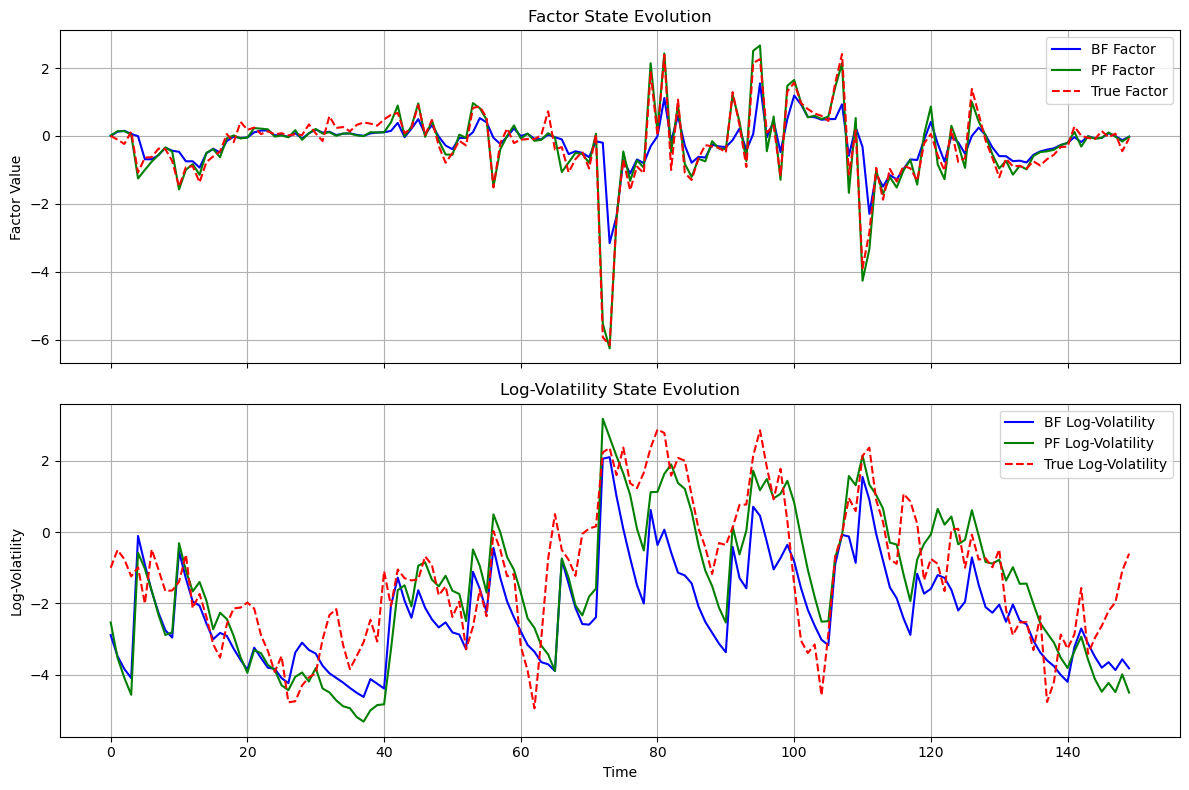

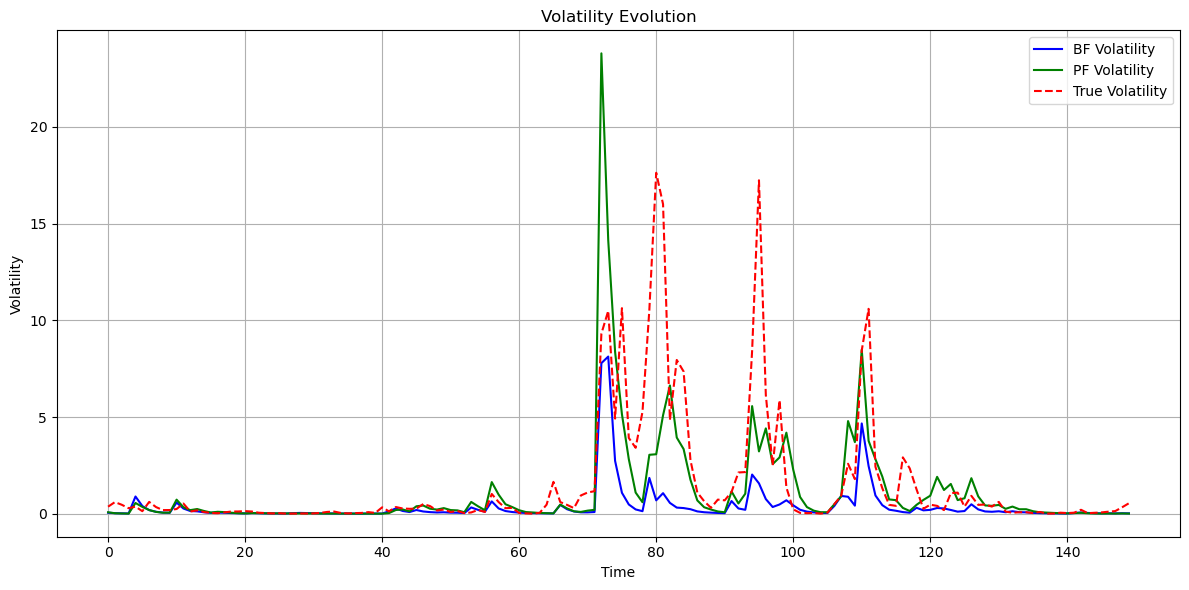

In [11]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot factor states
axes[0].plot(filtered_states_jaxopt[:, 0], "b-", label="BF Factor")
axes[0].plot(filtered_states_orig[:, 0], "g-", label="PF Factor")
axes[0].plot(factors[:, 0], "r--", label="True Factor")
axes[0].set_title("Factor State Evolution")
axes[0].set_ylabel("Factor Value")
axes[0].grid(True)
axes[0].legend()

# Plot log-volatility states
axes[1].plot(filtered_states_jaxopt[:, 1], "b-", label="BF Log-Volatility")
axes[1].plot(filtered_states_orig[:, 1], "g-", label="PF Log-Volatility")
axes[1].plot(log_vols[:, 0], "r--", label="True Log-Volatility")
axes[1].set_title("Log-Volatility State Evolution")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Log-Volatility")
axes[1].grid(True)
axes[1].legend()

# Also print the correlation values for reference
# plt.figtext(
#     0.5,
#     0.01,
#     f"Factor correlation: {factor_corr:.4f}, Log-vol correlation: {vol_corr:.4f}",
#     ha="center",
#     fontsize=12,
#     bbox={"facecolor": "orange", "alpha": 0.2, "pad": 5},
# )

plt.tight_layout()
plt.show()

# Create a new figure for volatility (exp of log-volatility)
plt.figure(figsize=(12, 6))
plt.plot(np.exp(filtered_states_jaxopt[:, 1]), "b-", label="BF Volatility")
plt.plot(np.exp(filtered_states_orig[:, 1]), "g-", label="PF Volatility")
plt.plot(np.exp(log_vols[:, 0]), "r--", label="True Volatility")
plt.title("Volatility Evolution")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
print(ll_orig)

10118.53073048374
